# 2. Black-Scholes Baseline

This notebook implements and evaluates the standard Black-Scholes model as the baseline for option pricing. Despite its simplifying assumptions, the Black-Scholes model remains a foundational benchmark for option pricing. In this notebook, we use it to evaluate market prices and establish a baseline before introducing more flexible models like Heston.

## Goals
- Implement analytical formulas for Black-Scholes pricing of **vanilla** European options (calls and puts).
- Compute theoretical option prices using real market data.
- Calculate key **Greeks**: Delta, Gamma, Vega, Theta, and Rho.
- Evaluate the model's accuracy by comparing theoretical prices with observed market mid prices.
- Visualize volatility surfaces and model pricing errors.

## Structure
1. **Environment & Data**: Load cleaned options dataset and libraries.
2. **Black-Scholes Functions**: Pricing formula and Greeks.
3. **Application to Market Data**: Compute theoretical prices and compare with mid prices.
4. **Visualizations**: Price surfaces, Greeks, and model error heatmaps.
5. **Conclusion**: Performance analysis and motivation for moving beyond Black-Scholes.

*Note* This introduction is done mainly in a very theoretical framwork. If you want to skip the derivation, go directly to section 3.

## 1. Environment & Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from matplotlib.colors import LogNorm

In [2]:
data_path  = '../data/options_cleaned.csv'
options_df = pd.read_csv(data_path)
options_df.head()

,strike,bid,ask,lastPrice,openInterest,impliedVolatility,Type,T,mid,spread,risk_free_rate,Underlying_price
0,4000.0,2411.3,2418.7,2267.07,338.0,3.019534,call,0.0,2415.00,7.4,0.0433,6408.129883
1,5000.0,1411.2,1415.8,1388.24,843.0,1.660646,call,0.0,1413.50,4.6,0.0433,6408.129883
2,5575.0,838.7,842.6,801.86,1001.0,1.076939,call,0.0,840.65,3.9,0.0433,6408.129883
3,5700.0,713.6,717.0,703.47,136.0,0.925690,call,0.0,715.30,3.4,0.0433,6408.129883
4,5800.0,614.5,617.7,566.46,108.0,0.829195,call,0.0,616.10,3.2,0.0433,6408.129883


## 2. Black-Scholes model: definition and theoretical solution.

The Black-Scholes model is a mathematical model used in the description of financial markets that contains derivative investment instruments. It was initially proposed by Fischer Black and Myron Scholes in 1973 in the article "The Pricing of Options and Corporate Liabilities".

### 2.1. Model assumptions.

The model make the following assumptions about the assets:
- Risk-free rate: The rate of return on the riskless asset is constant.
- Random walk: The instantaneous log return of the stock price is an infinitesimal random walk with constant drift and volatility.
- The stock does not pay a dividend.

On the other hand, the market asumpitons that are made are:
- No arbitrage opportunity (no way to make a riskless profit in excess of the risk-free rate).
- Ability to borrow and lend any amount of cash at the riskless rate.
- Ability to buy and sell any amount, even fractional, of the stock.
- The above transactions do not incur any fees or costs.

### 2.2. Black-Scholes equation derivation.

*Note*: All pricing and calibration in this notebook is done under the risk-neutral measure $\mathbb{Q}$, as standard in quantitative finance. The implied volatilities and risk-free rate are consistent with this framework.

In practical terms, this assumtions can be formalize by describing the evolution of the underlying asset as a stochastic process whose dynamical equation is a geometric brownian motion:

$$
dS_t = r_f \cdot S_t \cdot dt + \sigma\cdot S_t \cdot dW^{\mathbb{Q}}
$$

where $r_f$ is the risk-free rate, the $\sigma$ is the stock volatility and $dW^{\mathbb{Q}}$ is a diferential Wiener process, which constitues the only source of randomness in the model.

Now, by Ito's lemma, we can compute the evolution of any function $V(S_t, t)$ that depends on $S_t$. The differential equation obtained is:

$$
dV = \left(\frac{\partial V}{\partial t} +  r_f S_t \,\frac{\partial V}{\partial S_t} + \frac{1}{2}\,\sigma^2 S^2 \,\frac{\partial^2 V}{\partial S^2}\right)\cdot dt + \sigma S_t\,\frac{\partial V}{\partial S_t} \,dW^{\mathbb{Q}}
$$

The last financial instrument that we are going to take is a portfolio $\Pi$ consisting of a single option with value $V(S_t, t)$ and the underlying $S_t$. The value of the portfolio is given by:

$$
\Pi = V(S_t, t) + N_s \cdot S_t
$$

and its evolution by:

$$
d\Pi = \left[ \frac{\partial V}{\partial t} + r_f S_t\,\frac{\partial V}{\partial S} + \frac{1}{2}\,\sigma^2 S_t^2\,\frac{\partial^2 V}{\partial S^2} + N_s r_f S_t \right] \,dt + \sigma\,S_t\cdot\left[\frac{\partial V}{\partial S} + N_s  \right] \,dW^{\mathbb{Q}}
$$

Note now that we can remove the dependence of $\Pi$ with the underlying noise $dW^{\mathbb{Q}}$ by selecting $N_s = -\frac{\partial V}{\partial S}$. This is called **delta-hedge** and is fundamental in portfolio managment as, according to Black-Scholes model, the portfolio is now riskless.
$$
d\Pi =  \left[ \frac{\partial V}{\partial t} + \frac{1}{2}\,\sigma^2 S_t^2\,\frac{\partial^2 V}{\partial S^2}  \right] \,dt 
$$

The rate of return on this portfolio must be equal to the rate of return on any other riskless instrument; otherwise, there would be opportunities for arbitrage. As a consequence:

$$
d\Pi = r_f \Pi dt = r_f\left[V(S_t, t) - \frac{\partial V}{\partial S} \cdot S_t  \right]\, dt
$$

By combining both formulas, we arrive at the Black–Scholes partial differential equation:

$$
\frac{\partial V}{\partial t} + r_f S_t \frac{\partial V}{\partial S} + \frac{1}{2}\sigma^2 S^2 \frac{\partial S^2}{\partial S^2} = rV
$$

### 2.3. Solution for the European vanilla option

The previous Black-Scholes equation has a known solution in the case of the European options. For the call options, the solution is:

$$
C(S, T, \sigma, r_f) = N(d_1) S - N(d_2)K e^{-r_f\,T}
$$

where $N(x)$ is the normal cumulative function, $K$ is the striking price, $T$ the time to maturity and
$$
d_1 = \frac{1}{\sigma \sqrt{T}}\,\left[\ln\left(\frac{S}{K}\right) +  \left(r_f + \frac{\sigma^2}{2}\right) T\right]
$$
$$
d_2 = d_1 - \sigma \sqrt{N}
$$

The price of the put option can be computed from this using the put-call parity:

$$
P(S, T, \sigma, r_f)  = K e^{-r_f T} - S + C(S, T, \sigma, r_f)
$$

### 2.4. Geeks options.

The Black-Scholes solution also gives the so called **option greeks** value. These measure the sensitivity of the value of a derivative product to changes in parameter values while holding the other parameters fixed. The most important are the following:
- Delta Greek.
$$
\Delta_{\text{call}}  = \frac{\partial V}{\partial S} = N(d_1) \quad \Delta_{\text{put}}  = \frac{\partial V}{\partial S} = N(d_1) - 1
$$

- Gamma Greek.
$$
\Gamma_{\text{call}} , \Gamma_{put} = \frac{\partial^2 V}{\partial S^2} = \frac{N'(d_1)}{S\sigma \sqrt{T}}
$$

There are additionally other three that should be taken into account:
- Vega Greek
$$
\nu_{\text{call}},\, \nu_{\text{put}} = \frac{\partial V}{\partial \sigma} = S N'(d_1) \sqrt{T}
$$

- Theta Greek.
$$
\Theta_{\text{call}} = \frac{\partial V}{\partial t} = - \frac{S N'(d_1) \sigma}{2\sqrt{T}} - rK e^{-r T}N(d_2)  \quad \Theta_{\text{put}} = \frac{\partial V}{\partial t} = - \frac{S N'(d_1) \sigma}{2\sqrt{T}} - rK e^{-r T}(N(d_2) - 1)
$$

- Rho Greek.
$$
\rho_{\text{call}} = \frac{\partial V}{\partial r} = K T e^{-r_f T} N(d_2) \quad \quad \rho_{\text{put}} =\frac{\partial V}{\partial r} = K T e^{-r_f T} (N(d_2) - 1)
$$

### 2.5. Code implementation

Although these expressions are complex, they can be easily computed with the `scipy.stats` library. The code is written in the `Black_scholes.py` script.

In [3]:
import sys
import os

script_path = os.path.abspath(os.path.join("..", "Scripts"))
if script_path not in sys.path:
    sys.path.append(script_path)

import Black_scholes 

## 2.3. Application to real market data

In this section, I will apply the princing functions to the real market data obtained in `01_Collect_&_explore.ipynb`.

In [4]:
BS_df = options_df[['T', 'strike', 'Underlying_price', 'risk_free_rate', 'impliedVolatility', 'Type', 'mid']].copy()
BS_df['Prices'] = BS_df.apply(
    lambda row: Black_scholes.Black_Scholes_pricing(
        row['T'] + 1e-8,  #avoid divison by 0
        row['strike'],
        row['Underlying_price'],
        row['risk_free_rate'],
        row['impliedVolatility'],
        row['Type']
    ),
    axis=1
)

BS_df['Error'] = np.abs(BS_df['Prices'] - BS_df['mid'])
BS_df['Rel_error'] = BS_df['Error']/BS_df['mid'] * 100
BS_df.head()

,T,strike,Underlying_price,risk_free_rate,impliedVolatility,Type,mid,Prices,Error,Rel_error
0,0.0,4000.0,6408.129883,0.0433,3.019534,call,2415.00,2408.129885,6.870115,0.284477
1,0.0,5000.0,6408.129883,0.0433,1.660646,call,1413.50,1408.129885,5.370115,0.379916
2,0.0,5575.0,6408.129883,0.0433,1.076939,call,840.65,833.129885,7.520115,0.894560
3,0.0,5700.0,6408.129883,0.0433,0.925690,call,715.30,708.129885,7.170115,1.002393
4,0.0,5800.0,6408.129883,0.0433,0.829195,call,616.10,608.129885,7.970115,1.293640


In [5]:
BS_df['Delta'] = BS_df.apply(
    lambda row: Black_scholes.Black_Scholes_Delta(
        row['T'] + 1e-8,  #avoid divison by 0
        row['strike'],
        row['Underlying_price'],
        row['risk_free_rate'],
        row['impliedVolatility'],
        row['Type']
    ),
    axis=1
)

BS_df['Gamma'] = BS_df.apply(
    lambda row: Black_scholes.Black_Scholes_Delta(
        row['T'] + 1e-8,  #avoid divison by 0
        row['strike'],
        row['Underlying_price'],
        row['risk_free_rate'],
        row['impliedVolatility'],
    ),
    axis=1
)

BS_df['Rho'] = BS_df.apply(
    lambda row: Black_scholes.Black_Scholes_Rho(
        row['T'] + 1e-8,  #avoid divison by 0
        row['strike'],
        row['Underlying_price'],
        row['risk_free_rate'],
        row['impliedVolatility'],
        row['Type']
    ),
    axis=1
)

BS_df['Vega'] = BS_df.apply(
    lambda row: Black_scholes.Black_Scholes_Vega(
        row['T'] + 1e-8,  #avoid divison by 0
        row['strike'],
        row['Underlying_price'],
        row['Gamma'],
        row['impliedVolatility'],
    ),
    axis=1
)

BS_df['Theta'] = BS_df.apply(
    lambda row: Black_scholes.Black_Scholes_Theta(
        row['T'] + 1e-8,  #avoid divison by 0
        row['strike'],
        row['Underlying_price'],
        row['risk_free_rate'],
        row['impliedVolatility'],
        row['Gamma'],
        row['Rho']
    ),
    axis=1
)

## 2.4. Visualizations.

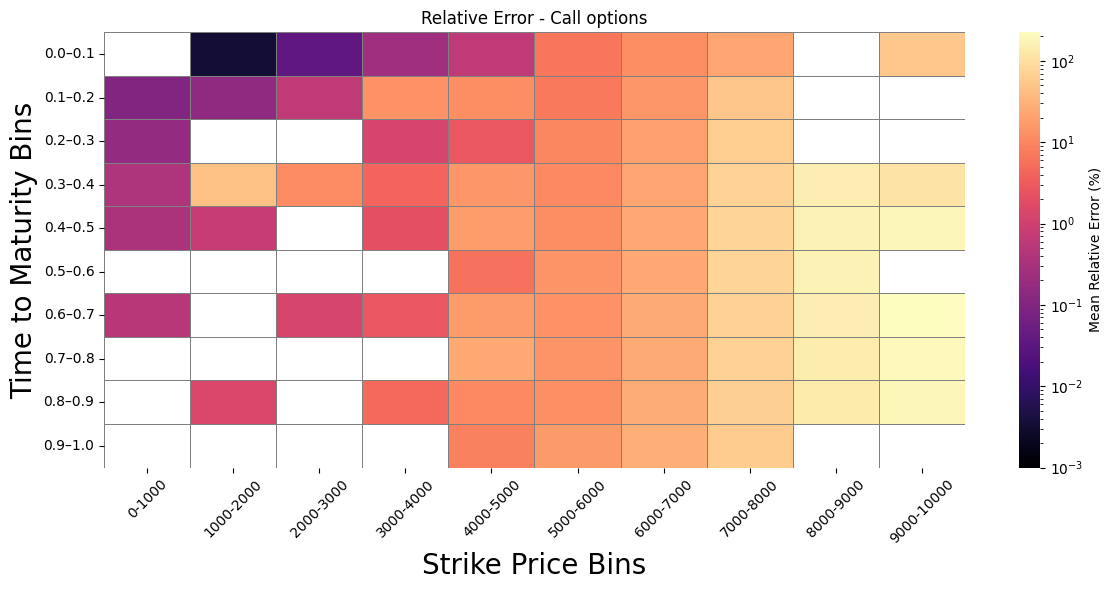

In [6]:
strike_bins = np.arange(0, 11000, 1000) 
T_bins = np.linspace(0, 1.0, 11) 

BS_df_call = BS_df[BS_df['Type'] == 'call'].copy()

BS_df_call['strike_bin'] = pd.cut(BS_df_call['strike'], bins=strike_bins)
BS_df_call['T_bin'] = pd.cut(BS_df_call['T'], bins=T_bins)


error_pivot = BS_df_call.pivot_table(
    index='T_bin',
    columns='strike_bin',
    values='Rel_error',
    aggfunc='mean',
    observed=False
)


error_pivot_safe = error_pivot.replace(0.0001, np.nan)

plt.figure(figsize=(12, 6))
sns.heatmap(
    error_pivot_safe,
    cmap='magma',
    norm=LogNorm(vmin=1e-3, vmax=np.nanmax(error_pivot_safe.values)),
    cbar_kws={'label': 'Mean Relative Error (%)'},
    linewidths=0.5,
    linecolor='gray'
)

plt.xticks(
    ticks=np.arange(len(error_pivot_safe.columns)) + 0.5, 
    labels=[f'{int(i.left)}-{int(i.right)}' for i in error_pivot_safe.columns],
    rotation=45
)

plt.yticks(
    ticks=np.arange(len(error_pivot_safe.index)) + 0.5,
    labels=[f'{round(i.left, 2)}–{round(i.right, 2)}' for i in error_pivot_safe.index]
)

plt.title("Relative Error - Call options")
plt.xlabel("Strike Price Bins", fontsize = 20)
plt.ylabel("Time to Maturity Bins", fontsize = 20)
plt.tight_layout()
plt.show()

The heatmap above displays the mean relative error between the Black-Scholes model and market prices, binned by strike price (x-axis) and time to maturity (y-axis).

### Key Observations:

Mid to long maturities and moderate strikes (central region) tend to exhibit lower relative errors, indicating better model performance in more liquid, near-the-money scenarios.

However, an important fact that should not be neglected, is that while the Black-Scholes model assumes that the volatility is constant, to compute this prices I have used the `Yahoo finance` implied volatility, which is not constant.

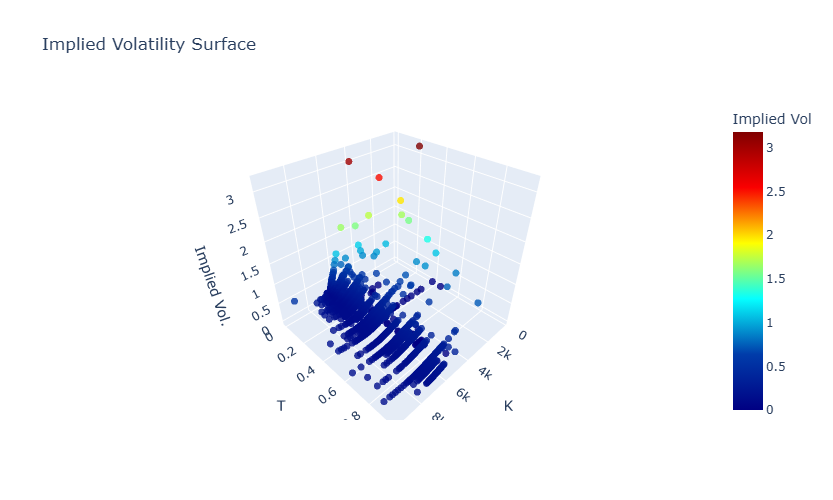

In [23]:
import plotly.graph_objects as go

df = BS_df_call.dropna(subset=['strike', 'T', 'impliedVolatility'])


fig = go.Figure(data=[go.Scatter3d(
    x=df['strike'],
    y=df['T'],
    z=df['impliedVolatility'],
    mode='markers',
    marker=dict(
        size=4,
        color=df['impliedVolatility'],      
        colorscale='jet',     
        colorbar=dict(title='Implied Vol'),
        opacity=0.8
    )
)])

fig.update_layout(
    title='Implied Volatility Surface',
    scene=dict(
        xaxis_title='K',
        yaxis_title='T',
        zaxis_title='Implied Vol.'
    ),
    width=600,
    height=500
)

This is specially relevant when we are dealing with options tha have the same maturity time. The options whose strike price differs substantially from the underlying asset's price command higher implied volatilities than what is suggested by standard option pricing models. Thus, by pricing options according to the Black-Scholes equations will give rise to an undervalue asset from which other traders might profit while we take the loss.

Text(0, 0.5, 'Implied Volatility')

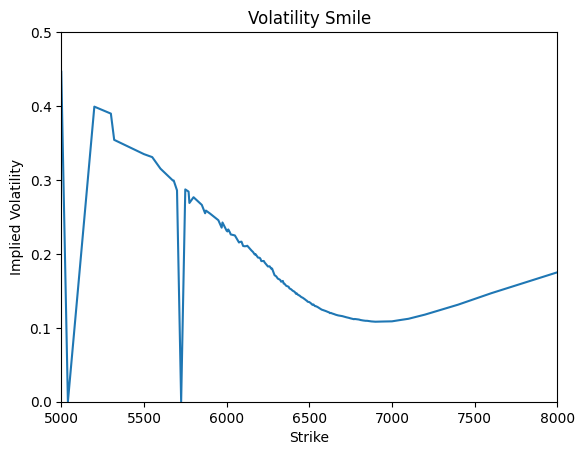

In [33]:
T = 0.1643835616438356
sns.lineplot(data=df[df['T'] == T], x='strike', y='impliedVolatility')
plt.title(f"Volatility Smile")
plt.xlabel("Strike")
plt.xlim(5000,8000)
plt.ylim(0,0.5)
plt.ylabel("Implied Volatility")

Of course, we can always take the observed implied volatilty of the market as the model volatility to price other options. However, while the observed implied volatility smile reflects market expectations and can reproduce option prices, it has important limitations:
- Model inconsistency: Black-Scholes assumes constant volatility. Using varying volatilities by strike breaks its assumptions and invalidates greeks.
- No extrapolation: The smile is only available for observed strikes and maturities. Pricing outside requires interpolation.
- Not generative: The smile doesn’t model the dynamics of volatility, so it can't be used for simulation or risk analysis.
- Static snapshot: It lacks structure to analyze how prices change with inputs like rates or spot movements.

## 2.5. Conclusión

The Black-Scholes model must be undestood as a milestone in the financial modelling theory that allow for the fist time to price options with relative simple assumptions. However, it is also important to take into account that the model shows some inconsistency problems that do not allow to use it in a naive way.

As a consequence, it is necessary to introduce other models to price options and perform risk analysis in an accurate manner. 